In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

plt.rcParams.update({'font.size':14})
plt.rcParams.update({"font.family" : "Times new roman"})

# Divide the dataset into Train-test split  and do the standard scalling

In [2]:
def split_transform(df,split_ratio):
    X=df.iloc[:,1:-1]
    Y=df.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=split_ratio,shuffle=True)

    scaler=StandardScaler()
    X_sc_train = scaler.fit_transform(X_train)
    X_sc_test = scaler.transform(X_test)

    print("The number of samples in the Training set is {}".format(len(X_sc_train)))
    print("The number of samples in the Test set is {}".format(len(X_sc_test)))
    
    return  X_sc_train, X_sc_test,y_train,y_test,scaler

# Import both Dataset

In [5]:
df1 =pd.read_csv(r'H:\Solar_panel_IFD\PreProcessed Data\Max_solar_data.csv')
df2=pd.read_csv(r'H:\Solar_panel_IFD\PreProcessed Data\Lim_solar_data.csv')
  
df = pd.concat([df1,df2], ignore_index=True, axis=0)

df.head()

,Time,Ipv,Vpv,Vdc,ia,ib,ic,va,vb,vc,Iabc,If,Vabc,Vf,label
0,0.000041,2.369843,90.429688,147.949219,0.616820,-0.530396,-0.160283,-146.003418,120.255127,25.595601,1.000000,50.000000,1.000000,50.000000,F0M
1,0.010040,2.378357,90.368652,148.242188,-0.678956,0.570679,0.047847,148.546906,-119.881439,-24.723663,1.000000,50.000000,1.000000,50.000000,F0M
2,0.020039,2.373627,90.460205,148.535156,0.603393,-0.537109,-0.187139,-145.027008,120.315399,26.109924,1.000000,50.000000,1.000000,50.000000,F0M
3,0.030038,2.368896,90.423584,148.242188,-0.685670,0.570679,0.041133,147.341461,-119.736786,-26.105906,0.440380,50.078491,118.275197,49.921509,F0M
4,0.040037,2.362274,90.435791,148.242188,0.630248,-0.523682,-0.166997,-143.279114,120.942230,26.680501,0.618996,50.248673,90.022162,49.606494,F0M


In [10]:
df['label'].unique()

array(['F0M', 'F1M', 'F2M', 'F3M', 'F4M', 'F5M', 'F6M', 'F7M', 'F0L',
       'F1L', 'F2L', 'F3L', 'F4L', 'F5L', 'F6L', 'F7L'], dtype=object)

In [11]:
X_sc_train, X_sc_test,y_train,y_test,scaler = split_transform(df,split_ratio=0.3)

The number of samples in the Training set is 15145
The number of samples in the Test set is 6491


In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [16]:
encoder= LabelEncoder()

In [17]:
y_train

8746     F6M
15160    F3L
5577     F4M
20618    F7L
3834     F2M
        ... 
7120     F5M
977      F0M
11905    F0L
6369     F4M
2479     F1M
Name: label, Length: 15145, dtype: object

In [18]:
encoder.fit(y_train)

LabelEncoder()

In [19]:
encoded_y = encoder.transform(y_train)

In [23]:
encoded_y

array([13,  6,  9, ...,  0,  9,  3])

In [25]:
to_categorical(encoded_y)[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

# One Hot Encoding the Fault Classes

In [29]:
encoder= LabelEncoder()
encoder.fit(y_train)
encoded_y = encoder.transform(y_train)
dummy_y = to_categorical(encoded_y)


encoded_y_test = encoder.transform(y_test)
dummy_y_test = to_categorical(encoded_y_test)

In [30]:
encoder.classes_

array(['F0L', 'F0M', 'F1L', 'F1M', 'F2L', 'F2M', 'F3L', 'F3M', 'F4L',
       'F4M', 'F5L', 'F5M', 'F6L', 'F6M', 'F7L', 'F7M'], dtype=object)

# Building ANN Model

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import EarlyStopping

In [27]:
n_inputs   =  X_sc_train.shape[1]
output_cls =  len(encoder.classes_)


# define Input
visible = Input(shape=(n_inputs,))

# define Hidden
#e = Dense(200,activation='relu')(visible)
#e = Dense(100,activation='relu')(e)
e = Dense(50,activation='relu')(visible)
e = Dense(100,activation='relu')(e)
# e = Dense(100,activation='relu')(e)
# define output
output = Dense(output_cls, activation='softmax')(e)


model = Model(inputs=visible, outputs=output)

# compile model

model.compile(optimizer='adam',
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
                  metrics=['accuracy'])

model.summary()



Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                700       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1616      
Total params: 7,416
Trainable params: 7,416
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Define early stopping
early_stop = EarlyStopping(monitor='val_accuracy',patience=40,verbose=1)

# fit the autoencoder model to reconstruct input
history = model.fit(X_sc_train, ## Training Feature
                    dummy_y,    ## Training Labels
                    epochs=500, 
                    batch_size=500, 
                    verbose=2, 
                    validation_data=(X_sc_test,dummy_y_test),
                    callbacks = early_stop,
                    shuffle=True)

#After training, we can plot the learning curves for the train and test sets to confirm the model learned the reconstruction problem well.

model.save(r'H:\Solar_panel_IFD\Trained_model\ANN_model_lim_pow.h5')

Epoch 1/500
31/31 - 0s - loss: 2.6043 - accuracy: 0.1492 - val_loss: 2.3747 - val_accuracy: 0.3049
Epoch 2/500
31/31 - 0s - loss: 2.1528 - accuracy: 0.4448 - val_loss: 1.8814 - val_accuracy: 0.5867
Epoch 3/500
31/31 - 0s - loss: 1.6259 - accuracy: 0.6456 - val_loss: 1.3647 - val_accuracy: 0.6896
Epoch 4/500
31/31 - 0s - loss: 1.1563 - accuracy: 0.7279 - val_loss: 0.9823 - val_accuracy: 0.7329
Epoch 5/500
31/31 - 0s - loss: 0.8537 - accuracy: 0.7741 - val_loss: 0.7633 - val_accuracy: 0.7738
Epoch 6/500
31/31 - 0s - loss: 0.6882 - accuracy: 0.7944 - val_loss: 0.6415 - val_accuracy: 0.7928
Epoch 7/500
31/31 - 0s - loss: 0.5884 - accuracy: 0.8178 - val_loss: 0.5610 - val_accuracy: 0.8156
Epoch 8/500
31/31 - 0s - loss: 0.5214 - accuracy: 0.8314 - val_loss: 0.5074 - val_accuracy: 0.8285
Epoch 9/500
31/31 - 0s - loss: 0.4734 - accuracy: 0.8481 - val_loss: 0.4654 - val_accuracy: 0.8379
Epoch 10/500
31/31 - 0s - loss: 0.4355 - accuracy: 0.8508 - val_loss: 0.4325 - val_accuracy: 0.8402
Epoch 11/

31/31 - 0s - loss: 0.0793 - accuracy: 0.9774 - val_loss: 0.1047 - val_accuracy: 0.9706
Epoch 84/500
31/31 - 0s - loss: 0.0785 - accuracy: 0.9774 - val_loss: 0.1049 - val_accuracy: 0.9693
Epoch 85/500
31/31 - 0s - loss: 0.0775 - accuracy: 0.9774 - val_loss: 0.1002 - val_accuracy: 0.9712
Epoch 86/500
31/31 - 0s - loss: 0.0763 - accuracy: 0.9783 - val_loss: 0.1036 - val_accuracy: 0.9709
Epoch 87/500
31/31 - 0s - loss: 0.0775 - accuracy: 0.9774 - val_loss: 0.1026 - val_accuracy: 0.9713
Epoch 88/500
31/31 - 0s - loss: 0.0752 - accuracy: 0.9792 - val_loss: 0.0990 - val_accuracy: 0.9717
Epoch 89/500
31/31 - 0s - loss: 0.0738 - accuracy: 0.9797 - val_loss: 0.0999 - val_accuracy: 0.9706
Epoch 90/500
31/31 - 0s - loss: 0.0757 - accuracy: 0.9779 - val_loss: 0.0998 - val_accuracy: 0.9698
Epoch 91/500
31/31 - 0s - loss: 0.0732 - accuracy: 0.9793 - val_loss: 0.0988 - val_accuracy: 0.9724
Epoch 92/500
31/31 - 0s - loss: 0.0708 - accuracy: 0.9802 - val_loss: 0.0985 - val_accuracy: 0.9717
Epoch 93/500


Epoch 165/500
31/31 - 0s - loss: 0.0506 - accuracy: 0.9846 - val_loss: 0.0819 - val_accuracy: 0.9777
Epoch 166/500
31/31 - 0s - loss: 0.0490 - accuracy: 0.9855 - val_loss: 0.0826 - val_accuracy: 0.9775
Epoch 167/500
31/31 - 0s - loss: 0.0498 - accuracy: 0.9847 - val_loss: 0.0824 - val_accuracy: 0.9784
Epoch 168/500
31/31 - 0s - loss: 0.0480 - accuracy: 0.9856 - val_loss: 0.0834 - val_accuracy: 0.9780
Epoch 169/500
31/31 - 0s - loss: 0.0478 - accuracy: 0.9861 - val_loss: 0.0841 - val_accuracy: 0.9784
Epoch 170/500
31/31 - 0s - loss: 0.0478 - accuracy: 0.9857 - val_loss: 0.0838 - val_accuracy: 0.9767
Epoch 171/500
31/31 - 0s - loss: 0.0489 - accuracy: 0.9849 - val_loss: 0.0843 - val_accuracy: 0.9775
Epoch 172/500
31/31 - 0s - loss: 0.0474 - accuracy: 0.9855 - val_loss: 0.0809 - val_accuracy: 0.9786
Epoch 173/500
31/31 - 0s - loss: 0.0487 - accuracy: 0.9854 - val_loss: 0.0831 - val_accuracy: 0.9772
Epoch 174/500
31/31 - 0s - loss: 0.0496 - accuracy: 0.9850 - val_loss: 0.0830 - val_accurac

31/31 - 0s - loss: 0.0392 - accuracy: 0.9876 - val_loss: 0.0802 - val_accuracy: 0.9792
Epoch 247/500
31/31 - 0s - loss: 0.0392 - accuracy: 0.9875 - val_loss: 0.0809 - val_accuracy: 0.9781
Epoch 248/500
31/31 - 0s - loss: 0.0382 - accuracy: 0.9876 - val_loss: 0.0803 - val_accuracy: 0.9781
Epoch 249/500
31/31 - 0s - loss: 0.0395 - accuracy: 0.9875 - val_loss: 0.0853 - val_accuracy: 0.9774
Epoch 250/500
31/31 - 0s - loss: 0.0394 - accuracy: 0.9875 - val_loss: 0.0836 - val_accuracy: 0.9781
Epoch 251/500
31/31 - 0s - loss: 0.0395 - accuracy: 0.9874 - val_loss: 0.0799 - val_accuracy: 0.9792
Epoch 252/500
31/31 - 0s - loss: 0.0388 - accuracy: 0.9880 - val_loss: 0.0800 - val_accuracy: 0.9795
Epoch 253/500
31/31 - 0s - loss: 0.0383 - accuracy: 0.9880 - val_loss: 0.0847 - val_accuracy: 0.9774
Epoch 254/500
31/31 - 0s - loss: 0.0394 - accuracy: 0.9861 - val_loss: 0.0824 - val_accuracy: 0.9787
Epoch 255/500
31/31 - 0s - loss: 0.0388 - accuracy: 0.9871 - val_loss: 0.0789 - val_accuracy: 0.9795
Epoc

Epoch 328/500
31/31 - 0s - loss: 0.0321 - accuracy: 0.9894 - val_loss: 0.0927 - val_accuracy: 0.9777
Epoch 329/500
31/31 - 0s - loss: 0.0340 - accuracy: 0.9893 - val_loss: 0.0882 - val_accuracy: 0.9777
Epoch 330/500
31/31 - 0s - loss: 0.0333 - accuracy: 0.9897 - val_loss: 0.0867 - val_accuracy: 0.9795
Epoch 331/500
31/31 - 0s - loss: 0.0314 - accuracy: 0.9896 - val_loss: 0.0860 - val_accuracy: 0.9795
Epoch 332/500
31/31 - 0s - loss: 0.0340 - accuracy: 0.9883 - val_loss: 0.0890 - val_accuracy: 0.9784
Epoch 333/500
31/31 - 0s - loss: 0.0331 - accuracy: 0.9892 - val_loss: 0.0909 - val_accuracy: 0.9792
Epoch 334/500
31/31 - 0s - loss: 0.0314 - accuracy: 0.9898 - val_loss: 0.0853 - val_accuracy: 0.9798
Epoch 335/500
31/31 - 0s - loss: 0.0309 - accuracy: 0.9899 - val_loss: 0.0932 - val_accuracy: 0.9787
Epoch 336/500
31/31 - 0s - loss: 0.0316 - accuracy: 0.9898 - val_loss: 0.0882 - val_accuracy: 0.9792
Epoch 00336: early stopping


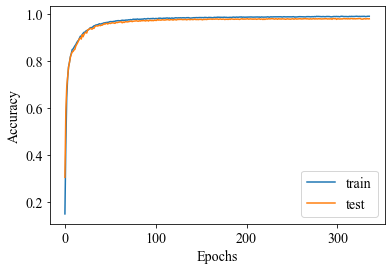

In [32]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Using the Trained Model For Validation

In [39]:
model.predict(X_sc_test)[0].argmax()

12

In [41]:
encoder.inverse_transform([12])

array(['F6L'], dtype=object)

In [42]:
y_pred = model.predict(X_sc_test) # see how the model did!
y_pred = y_pred.argmax(axis=1)
y_pred = encoder.inverse_transform(y_pred)


from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

Acc=accuracy_score(y_test,y_pred)
Pre=precision_score(y_test,y_pred,average='weighted')
Rec= recall_score(y_test,y_pred,average='weighted')
F1= f1_score(y_test,y_pred,average='weighted')

In [43]:
print("The average accuracy is -> {}".format(Acc))
print("")
print("The weighted Precision is -> {}".format(Pre))
print("")
print("The weighted Recall is -> {}".format(Rec))
print("")
print("The F1 score is -> {}".format(F1))
print("")

The average accuracy is -> 0.979201971961177

The weighted Precision is -> 0.979204162873644

The weighted Recall is -> 0.979201971961177

The F1 score is -> 0.9790862783903681



# Plot the Confusion Matrix

<Figure size 720x720 with 0 Axes>

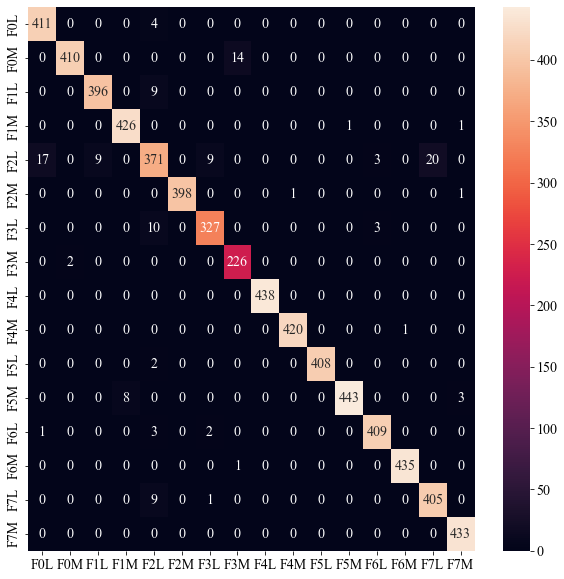

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(10,10))

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10,10))
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d',xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

# MissClassification Rate

In [45]:
arr = np.array(y_test!=y_pred)*1
count = arr[arr==1].shape[0]
print("Missclassification rate is {}%".format((count/len(y_test))*100))

Missclassification rate is 2.0798028038822984%


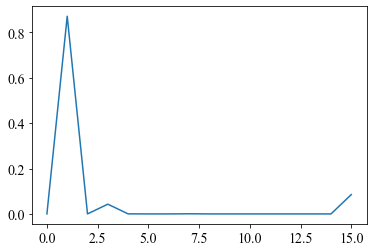

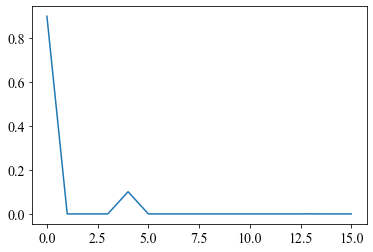

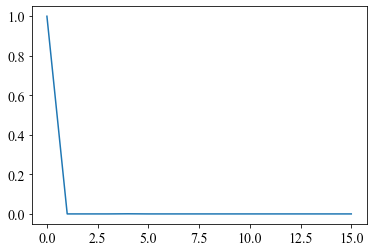

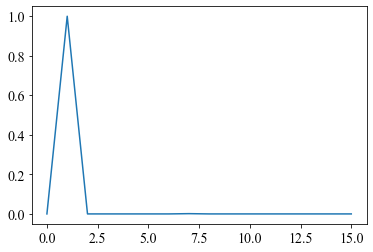

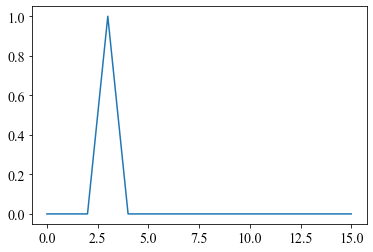

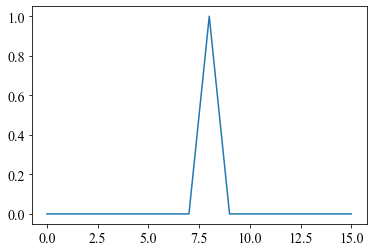

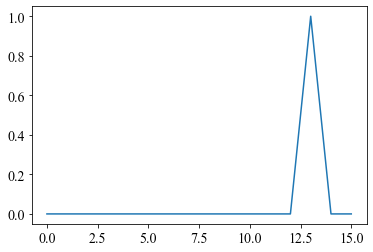

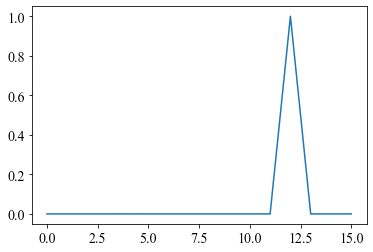

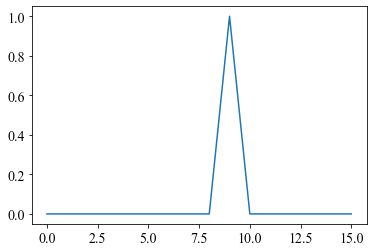

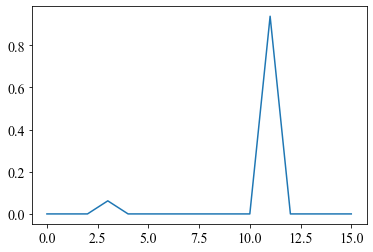

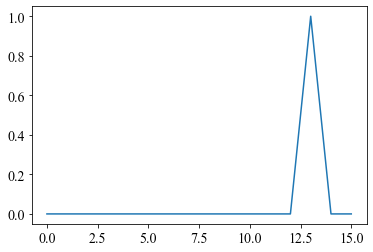

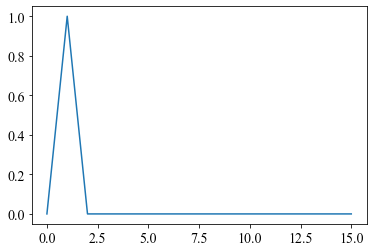

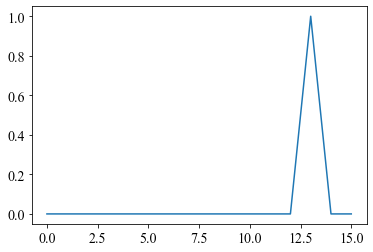

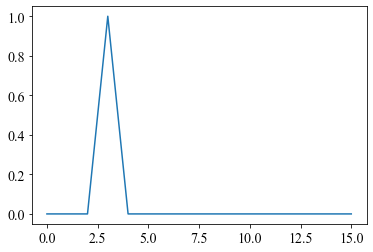

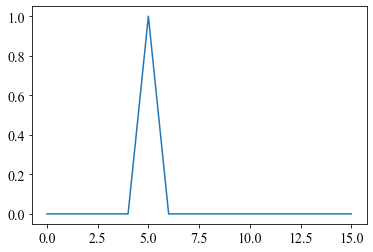

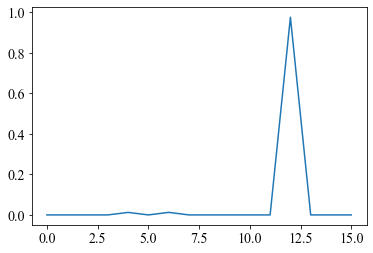

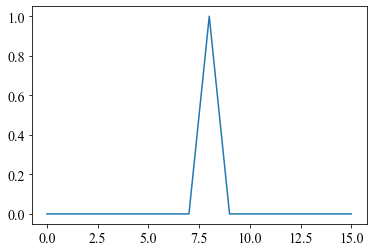

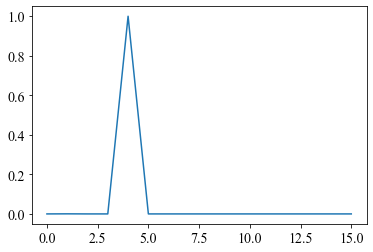

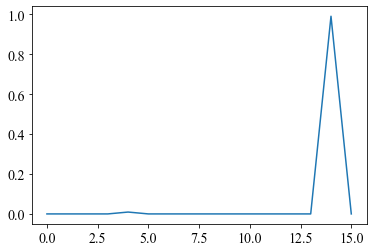

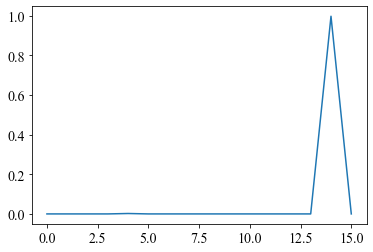

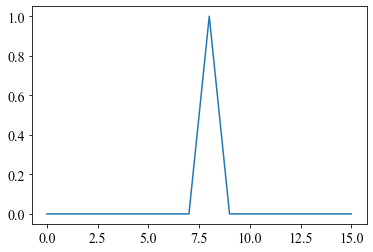

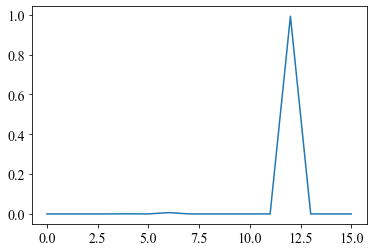

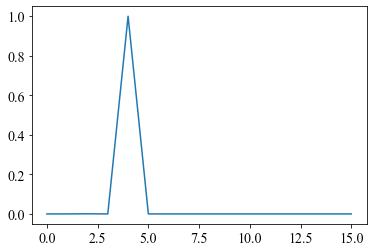

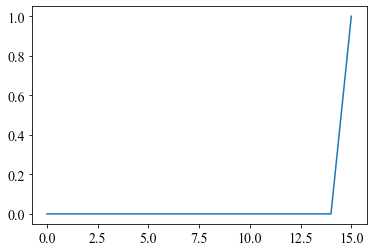

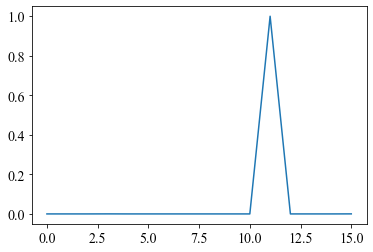

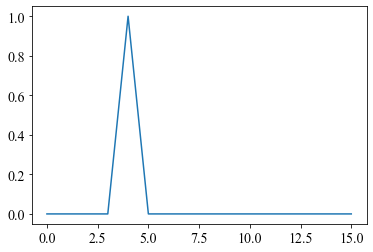

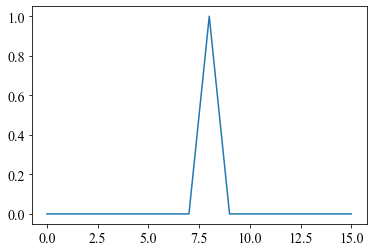

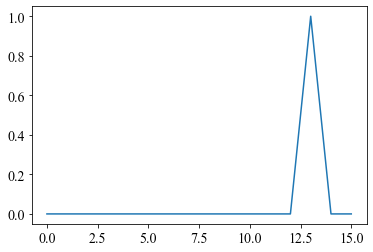

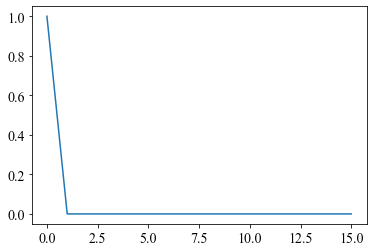

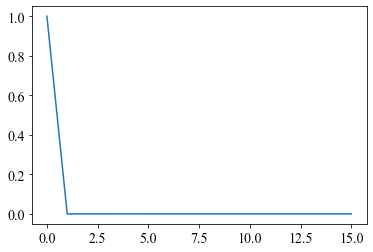

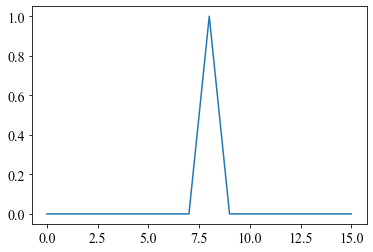

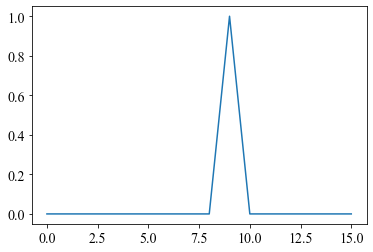

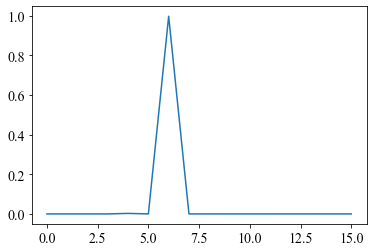

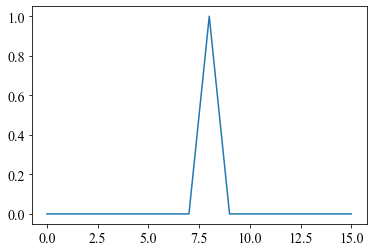

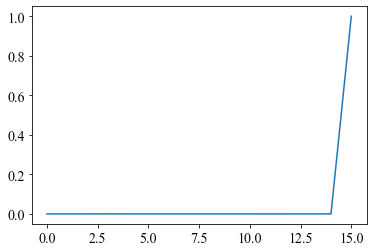

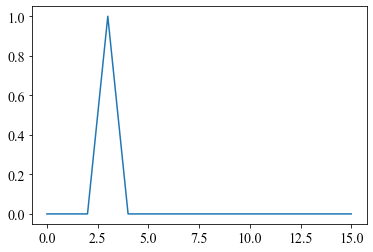

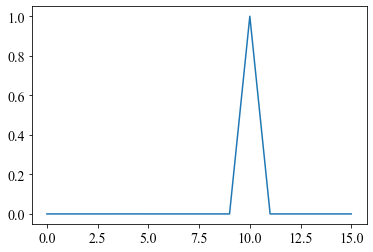

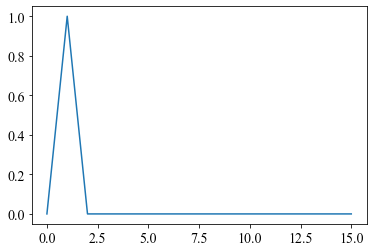

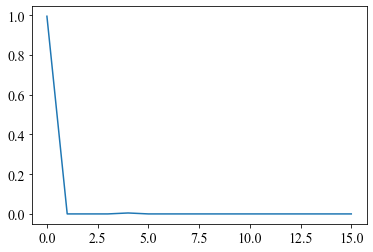

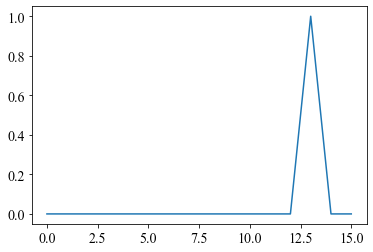

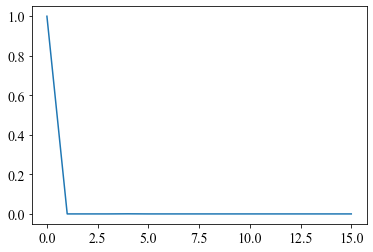

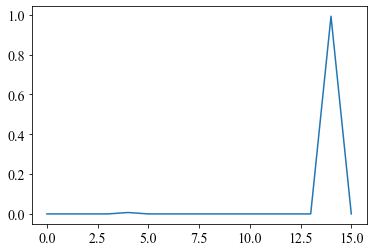

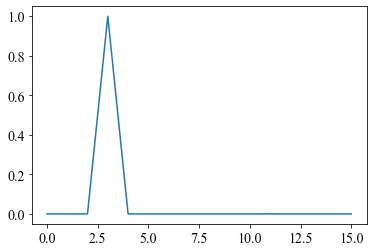

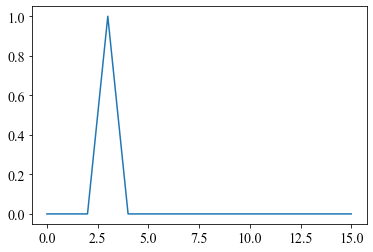

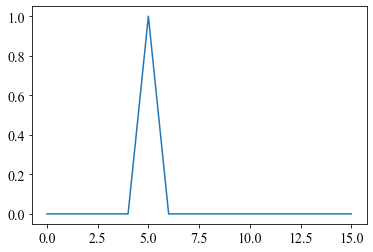

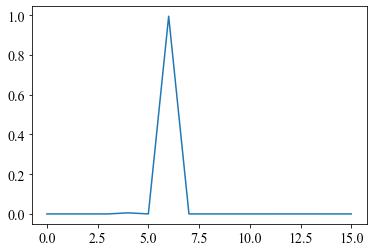

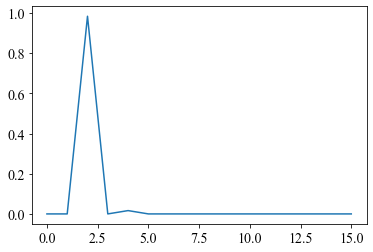

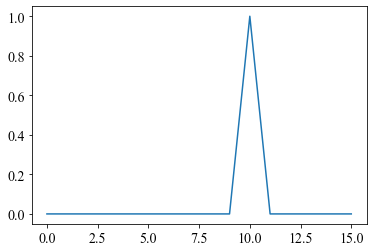

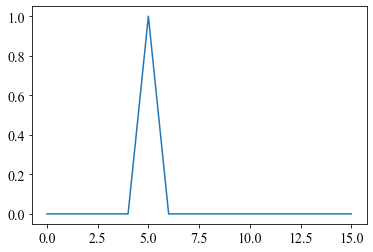

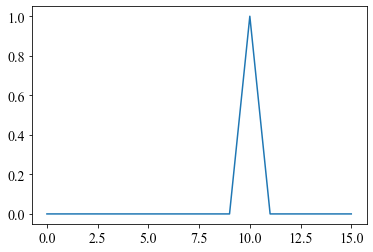

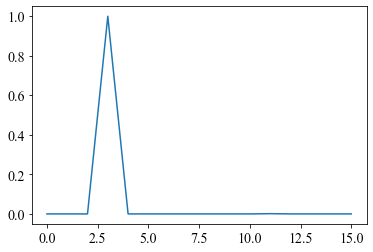

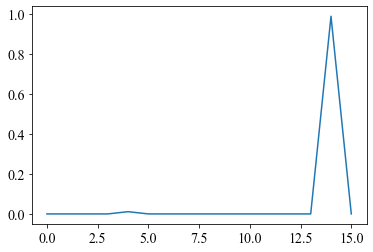

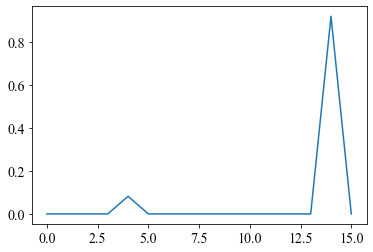

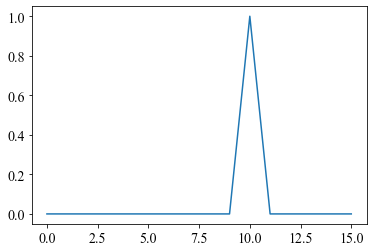

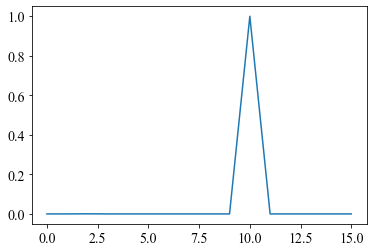

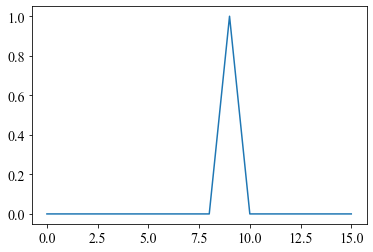

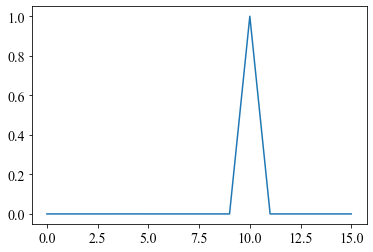

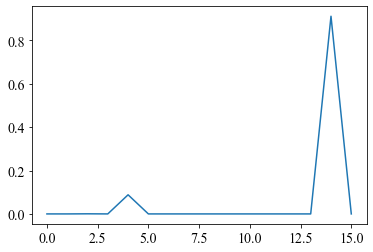

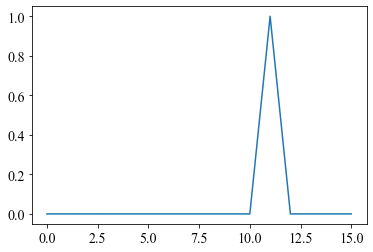

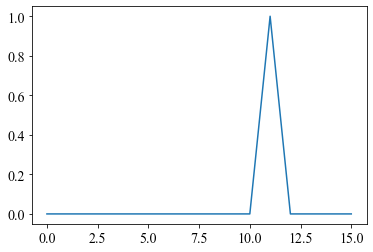

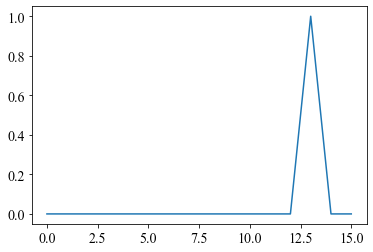

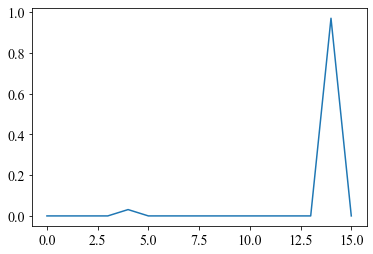

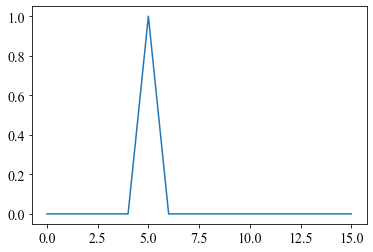

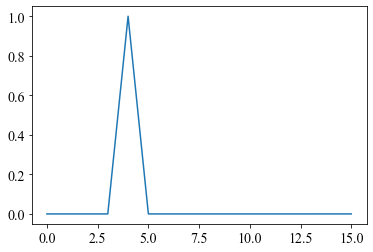

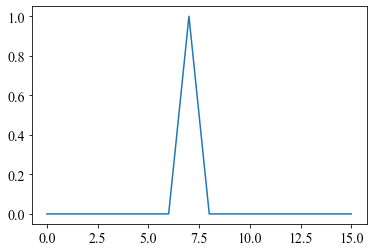

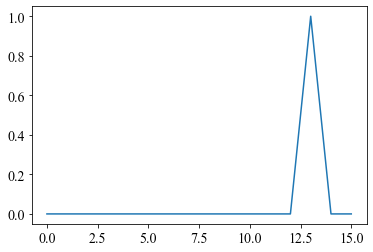

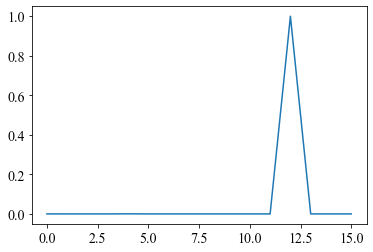

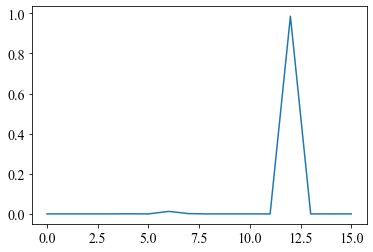

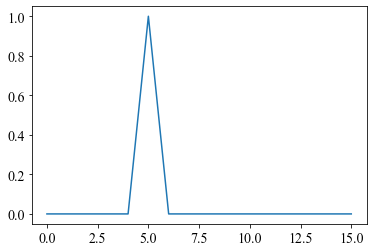

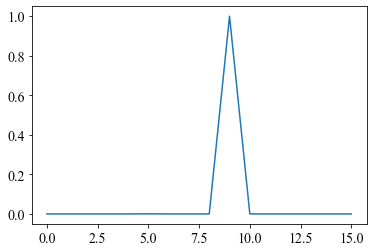

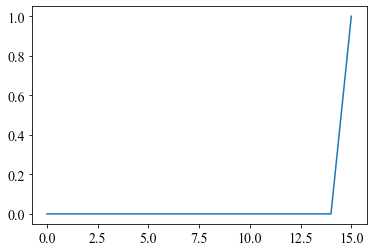

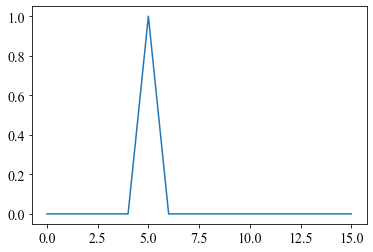

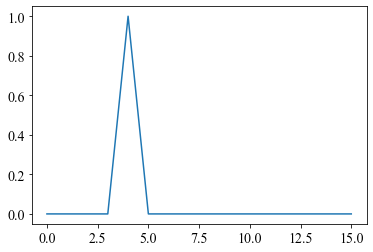

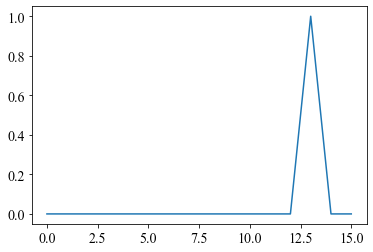

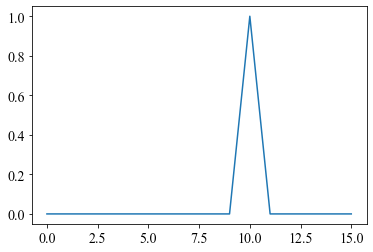

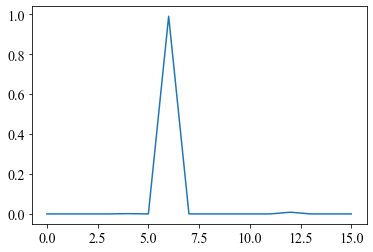

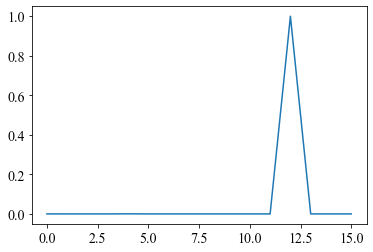

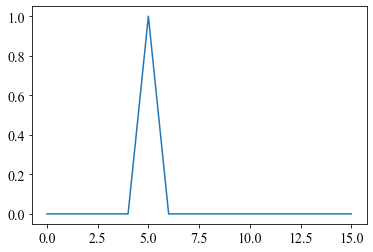

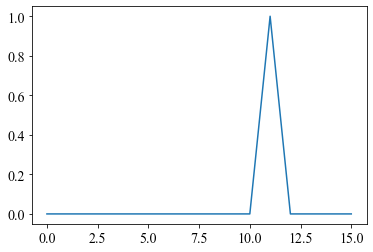

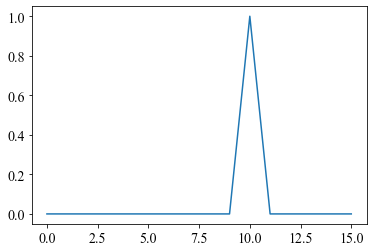

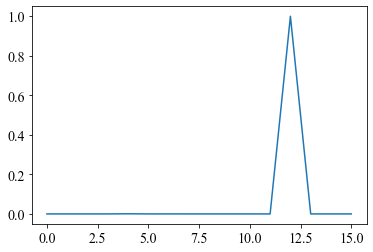

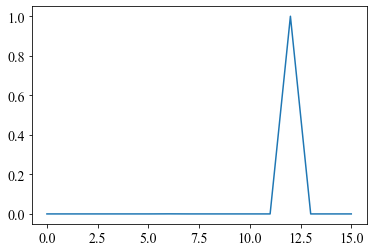

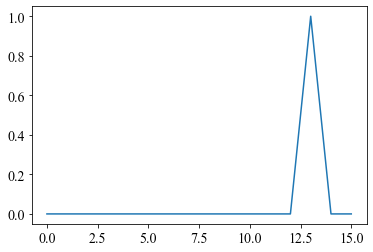

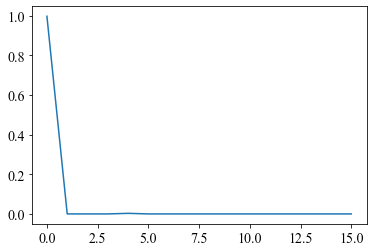

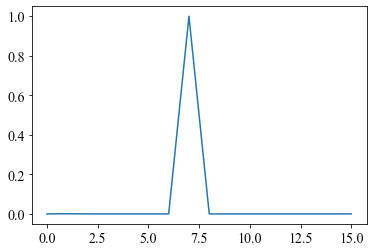

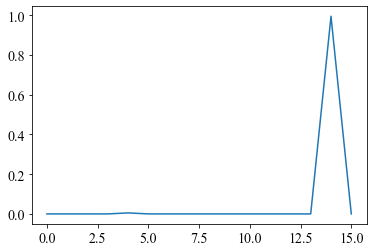

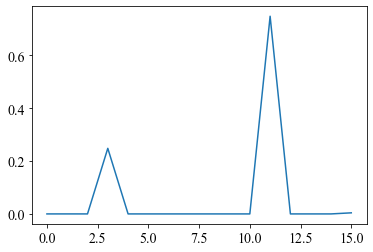

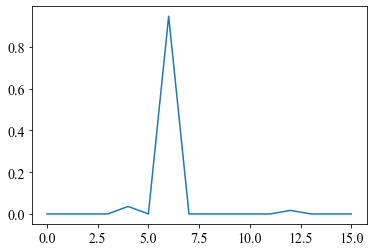

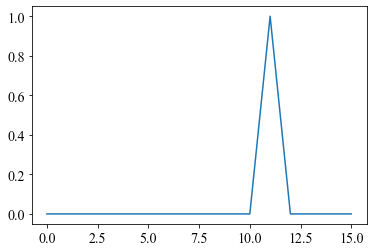

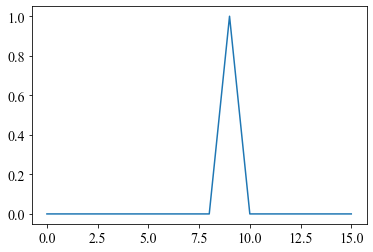

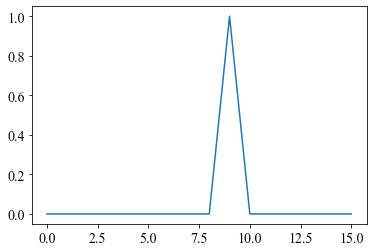

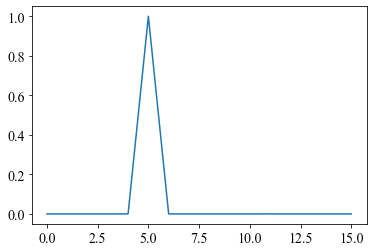

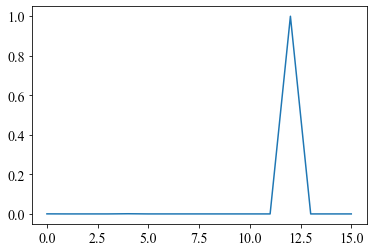

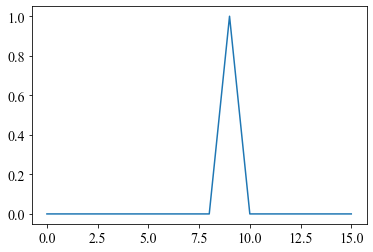

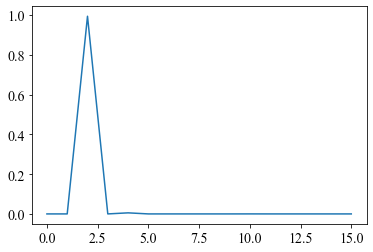

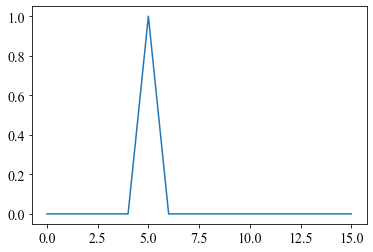

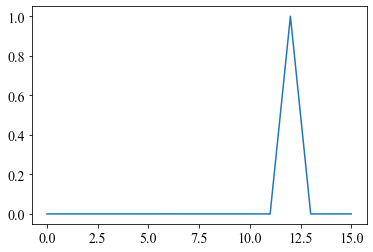

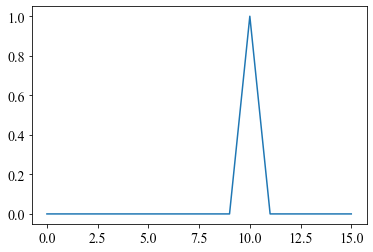

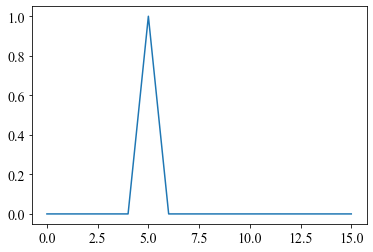

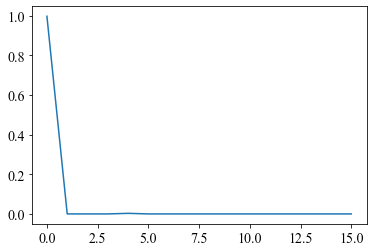

In [46]:
for i in range (100):
    
    plt.plot(model.predict(X_sc_test)[np.random.randint(0,1000,1)[0]])
    plt.show()